In [8]:
import os
import glob
import math
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
import tqdm
import xarray as xr
import rioxarray as rxr
import pystac_client
from pystac_client import Client
import odc.stac
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import dask
import dask.array as da
import dask.delayed

In [5]:
lulc_gdf = gpd.read_file("./lulc_utm_subset.geojson")

In [6]:
# Get the bounds of the forest polygons to define the AOI
aoi = lulc_gdf.to_crs(epsg="4326").total_bounds  # (minx, miny, maxx, maxy)
aoi

array([169.22028555, -19.65564097, 169.4692925 , -19.41891452])

In [9]:
# Access AWS STAC for Sentinel-2 Data
aws_stac_url = "https://earth-search.aws.element84.com/v1"
stac_client = Client.open(aws_stac_url)

In [10]:
# Search Sentinel-2 data on AWS with cloud cover less than 20%
s2_search = stac_client.search(
    collections=["sentinel-2-l2a"],
    bbox=list(aoi),
    datetime="2018-01-01/2018-12-31", 
    query={"eo:cloud_cover": {"lt": 5}}  # Filter by cloud cover < 5%
)

In [11]:
# Retrieve all items from search results
s2_items = s2_search.item_collection()

In [12]:
len(s2_items)

9

In [15]:
s2_data = odc.stac.load(
    items=s2_items,
    bands=["red", "green", "blue", "nir", "swir16", "scl"],
    bbox=aoi,
    chunks={'x': 1024, 'y': 1024, 'bands': -1, 'time': -1},
    resolution=20,
)

In [16]:
s2_data_nodata = s2_data["scl"].nodata
s2_data_nodata

0

In [17]:
bands = ['red', 'green', 'blue', 'nir', 'swir16']

In [18]:
cloud_classes = [3, 7, 8, 9, 10]  # Cloud-related SCL classes
cloud_mask = s2_data['scl'].isin(cloud_classes)
s2_data_masked = s2_data[bands].where(~cloud_mask, drop=False)  # Keep all pixels

In [19]:
# Average across the time dimension
s2_data_composite = s2_data_masked.median(dim='time')

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


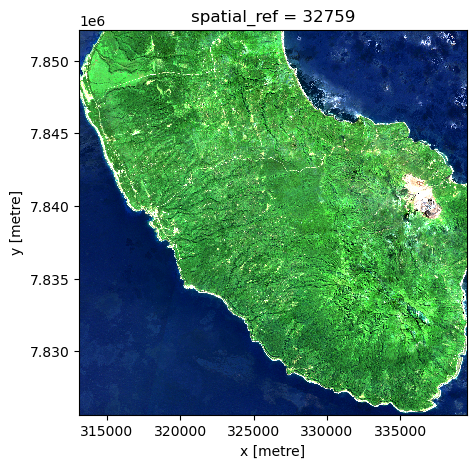

In [20]:
s2_data_composite[["red", "green", "blue"]].to_array("band").plot.imshow(rgb="band", robust=True, size=5, aspect=1)

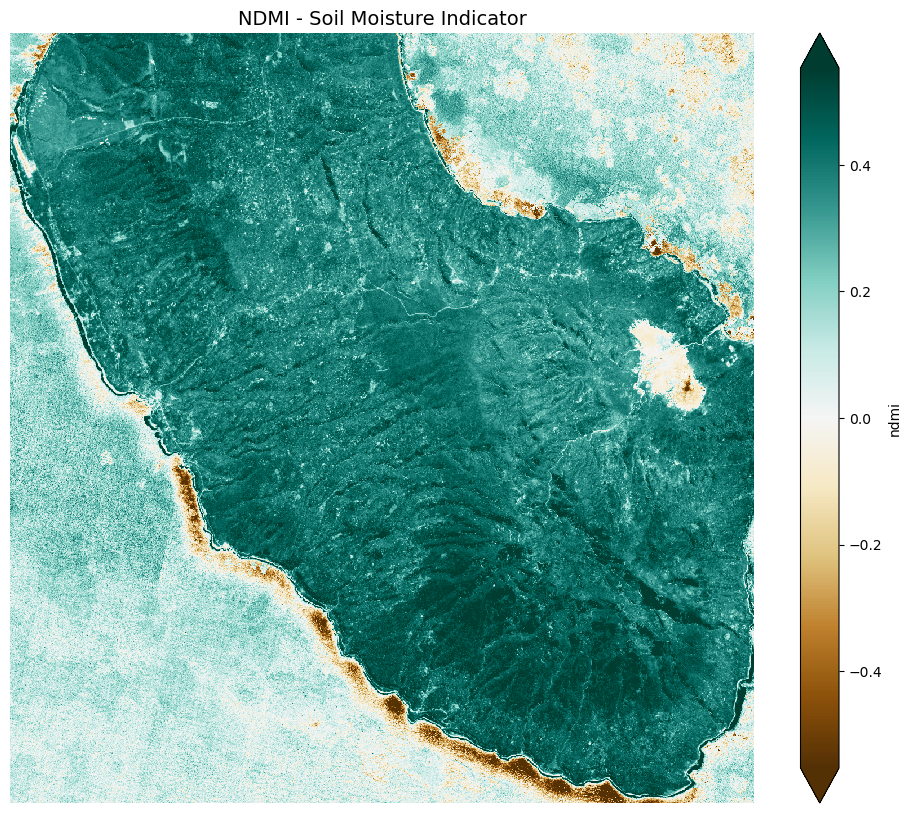

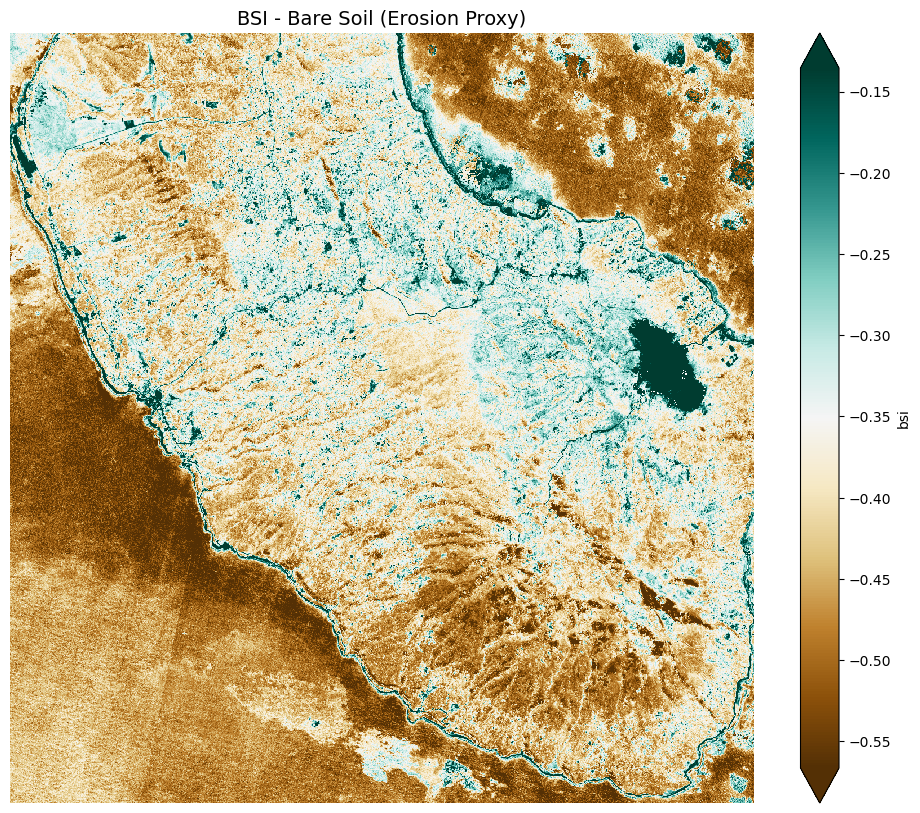

In [23]:
# Index functions
def compute_ndmi(nir, swir):
    return (nir - swir) / (nir + swir)

def compute_bsi(blue, red, nir, swir):
    return ((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))

# Compute indices
ndmi = compute_ndmi(s2_data_composite['nir'], s2_data_composite['swir16'])
bsi = compute_bsi(
    s2_data_composite['blue'],
    s2_data_composite['red'],
    s2_data_composite['nir'],
    s2_data_composite['swir16']
)

# Add indices to the dataset
s2_data_composite = s2_data_composite.assign(
    ndmi=ndmi,
    bsi=bsi
)

def plot_index(index_data, title, cmap='BrBG'):
    plt.figure(figsize=(12, 10))
    index_data.plot(cmap=cmap, robust=True)
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()

plot_index(s2_data_composite['ndmi'], 'NDMI - Soil Moisture Indicator')
plot_index(s2_data_composite['bsi'], 'BSI - Bare Soil (Erosion Proxy)')

